In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from pandas import DataFrame

In [2]:
from matplotlib import rcParams
rcParams.update({
    "font.size": 14})

## Load in FEM Validation Data

In [3]:
burgers = scipy.io.loadmat('matlab/burgers.mat')
X_ = torch.from_numpy(burgers['X']).reshape(-1).float()
T_ = torch.from_numpy(burgers['T']).reshape(-1).float()
u_ = torch.from_numpy(burgers['u']).reshape(-1).float()
X_.requires_grad = True
T_.requires_grad = True
xmin = X_.min().item()
xmax = X_.max().item()
N_x = X_.shape[0]

In [22]:
true_nu = 1/(100*torch.pi)

In [23]:
X_.shape, T_.shape, u_.shape

(torch.Size([301]), torch.Size([101]), torch.Size([301, 101]))

In [5]:
u_ = u_.reshape(X_.shape[0], T_.shape[0])

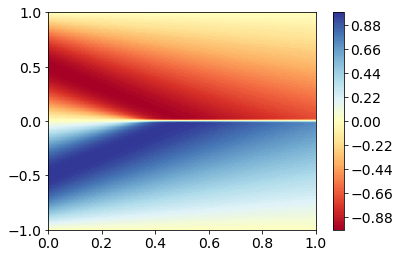

In [6]:
## Evaluate FEM-solution
x_, t_ = torch.meshgrid(X_, T_, indexing='ij')
plt.contourf(t_.detach(), x_.detach(), u_.detach(), levels=100, cmap='RdYlBu')
plt.colorbar()
plt.show()

In [7]:
x_eval = x_.reshape(-1, 1)
t_eval = t_.reshape(-1, 1)

## Holdout

In [8]:
N_train = 1000
p_train = N_train/x_.numel()
p_test = 1 - p_train
print('p_train', p_train)

p_train 0.03289365481398638


In [10]:
from sklearn.model_selection import ShuffleSplit

# Split dataset into train and test set (without stratification).
shuffleSplit = ShuffleSplit(n_splits=1, test_size=p_test, train_size=p_train).split(x_.reshape(-1, 1))
train_ids, test_ids = next(iter(shuffleSplit))

x_train = x_.reshape(-1, 1)[train_ids]
t_train = t_.reshape(-1, 1)[train_ids]
u_train = u_.reshape(-1, 1)[train_ids]

x_test = x_.reshape(-1, 1)[test_ids]
t_test = t_.reshape(-1, 1)[test_ids]
u_test = u_.reshape(-1, 1)[test_ids]

x_train.shape

torch.Size([999, 1])

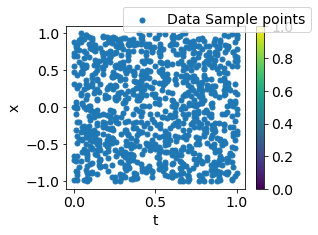

In [11]:
fig, ax = plt.subplots(figsize=(4,3))
d = ax.scatter(t_train.detach(), x_train.detach(), marker='.', s=100, label='Data Sample points')
fig.colorbar(d)
fig.legend()
ax.set_xlabel('t')
ax.set_ylabel('x')
plt.show()

## Defining the function and solution

In [12]:
_u_i = lambda x: -torch.sin(torch.pi*x)
_u_b = lambda t: 0*t

In [13]:
n_x = 20 # Number of data points in interior domain
n_i = 10 # Number of initial points
n_b = 10 # Number of boundary (time) points
n_t = 20 
# xmin = -1
# xmax = 1

# Interior of domain
X = torch.linspace(xmin, xmax, n_x+2, requires_grad=True)[1:-1]
T = torch.linspace(0, 1, n_t+1, requires_grad=True)[1:]
x, t = torch.meshgrid((X, T), indexing='ij')
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)

# Initial
x_i = torch.linspace(xmin, xmax, n_i,requires_grad=True).reshape(-1, 1)[1:-1]
t_i = torch.zeros(x_i.shape, requires_grad=True)
u_i = _u_i(x_i)

# Boundary
x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                 xmax*torch.ones(n_b, 1, requires_grad=True)))
t_b = torch.cat((torch.linspace(0, 1, n_b, requires_grad=True),
                torch.linspace(0, 1, n_b, requires_grad=True)), dim=0).reshape(-1, 1)
u_b = _u_b(t_b)

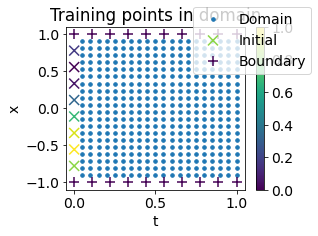

In [14]:
fig, ax = plt.subplots(figsize=(4,3))
d = ax.scatter(t.detach(), x.detach(), marker='.', s=50, label='Domain')
i = ax.scatter(t_i.detach(), x_i.detach(), c=u_i.detach(), marker='x', s=100, label='Initial')
b = ax.scatter(t_b.detach(), x_b.detach(), c=u_b.detach(), marker='+', s=100, label='Boundary')
fig.colorbar(d)
fig.legend()
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Training points in domain')
plt.show()

# Import Network

In [15]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out,
        N_hid = 30, N_layers=3,
        loss_func=nn.MSELoss(),
        learning_rate = 0.005,
        optimizer = optim.Adam,
        act_func=nn.Tanh()
                ):
        
        super(Net, self).__init__()

        # Initialise layers
        layers = [nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True), act_func]
        for _ in range(N_layers - 1):
            layers += [nn.Linear(in_features=N_hid,
                    out_features=N_hid,
                    bias=True), act_func]
        layers += [nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)]

        self.layers = nn.Sequential(*layers)

        self.nu = nn.parameter.Parameter(torch.ones(1))

        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        
        # Save hyperparameters
        self.N_hid = N_hid
        self.N_layers = N_layers
        self.act_func = act_func
        self.learning_rate = learning_rate
        self.N_params = sum([p.numel() for p in self.parameters()])
    
    def get_hyperparams(self):
        '''
        @returns: N_hid, N_layers, learning_rate, act_func, N_params
        '''
        return self.N_hid, self.N_layers, self.learning_rate, self.act_func, self.N_params 

    def forward(self, x, t):
        x = torch.cat((x, t), dim=1)
        out = self.layers(x)
        return out
    
    def PDE(self, x, t):
        u_hat = self.forward(x, t)
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_t_hat = torch.autograd.grad(u_hat, t, torch.ones(t.shape), create_graph=True)[0]
        
        pde = self.nu * u_xx_hat - u_hat * u_x_hat - u_t_hat.reshape(u_x_hat.shape)
        return pde

    def loss_PDE(self, x, t):
        pde = self.PDE(x, t)
        loss = self.loss_func(pde, torch.zeros(pde.shape, requires_grad=True))
        return loss
    
    def loss_BC(self, x_b, t_b, u_b):
        u_b_hat = self.forward(x_b, t_b)
        loss = self.loss_func(u_b, u_b_hat.reshape(u_b.shape))
        return loss
    
    def loss_IC(self, x_i, t_i, u_i):
        u_i_hat = self.forward(x_i, t_i)
        loss = self.loss_func(u_i, u_i_hat.reshape(u_i.shape))
        return loss
    
    def loss_data(self, x_train, t_train, u_train):
        u_hat = self.forward(x_train,t_train)
        loss = self.loss_func(u_train, u_hat.reshape(u_train.shape))
        return loss
    
    def loss(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i, x_train, t_train, u_train):
        loss_PDE = self.loss_PDE(x, t)
        loss_BC = self.loss_BC(x_b, t_b, u_b)
        loss_IC = self.loss_IC(x_i, t_i, u_i)
        loss_data = self.loss_data(x_train, t_train, u_train)
        loss = loss_PDE + loss_IC + loss_BC + loss_data
        return loss, loss_PDE, loss_IC, loss_BC, loss_data
    
    def step(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i, x_train, t_train, u_train):
        ''' Performs a backpropagation update.
        @returns: loss_PDE, loss_IC, loss_BC, loss_data
        '''
        self.train()
        self.optimizer.zero_grad()
        loss, loss_PDE, loss_IC, loss_BC, loss_data = self.loss(x, t, x_b, t_b, u_b, x_i, t_i, u_i, x_train, t_train, u_train)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return loss_PDE.detach().item(), loss_IC.detach().item(), loss_BC.detach().item(), loss_data.detach().item()

In [16]:
def MSE(net, u_, x, t):
    u_hat = net(x,t).detach().reshape(u_.shape)
    MSE = torch.mean((u_.detach() - u_hat)**2)
    return MSE

In [17]:
def progress(i, total):
    print("\r", '{:.2f}% '.format((i+1)*100/total), end="")

In [18]:
def number_of_parameters(net):
    return sum([p.numel() for p in net.parameters()])

In [19]:
from model_caching import save_model, load_model, get_model_name

## Optimal network

In [20]:
N_hid = 30
N_layers = 3
learning_rate = 0.001
act_func = nn.Tanh()
epochs = 5000

In [21]:
net = Net(N_in=2, N_out=1, N_hid=N_hid, N_layers=N_layers,
    learning_rate=learning_rate, act_func=act_func)
N_params = number_of_parameters(net)

**Training**

In [38]:
loss_pde, loss_bc, loss_ic, loss_data = torch.zeros(epochs), torch.zeros(epochs), torch.zeros(epochs), torch.zeros(epochs)
loss_nu = torch.zeros(epochs)
loss_test = torch.zeros(epochs)
for e in range(epochs):
    loss_pde[e], loss_bc[e], loss_ic[e], loss_data[e] = net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i, x_train, u_train, t_train)
    loss_nu[e] = net.nu.detach().item() - true_nu
    loss_test[e] = MSE(net, u_test, x_test, t_test)
    progress(e, epochs)
    if (e+1)%500 == 0:
        print('\nEpoch: {:d}. Test data loss: {:.3f}'.format(e+1, loss_test[e]))
        print('\nEpoch: {:d}. Nu deviation: {:.3f}'.format(e+1, loss_nu[e]))

 10.00% .44% 
Epoch: 500. Test data loss: 0.150

Epoch: 500. Nu deviation: 0.186
 20.00% 13.38% 
Epoch: 1000. Test data loss: 0.156

Epoch: 1000. Nu deviation: 0.189
 30.00% 24.92% 29.68% 
Epoch: 1500. Test data loss: 0.161

Epoch: 1500. Nu deviation: 0.192
 40.00% 
Epoch: 2000. Test data loss: 0.166

Epoch: 2000. Nu deviation: 0.195
 50.00% 43.02% 46.84% 
Epoch: 2500. Test data loss: 0.172

Epoch: 2500. Nu deviation: 0.199
 60.00% 
Epoch: 3000. Test data loss: 0.173

Epoch: 3000. Nu deviation: 0.202
 70.00% 
Epoch: 3500. Test data loss: 0.181

Epoch: 3500. Nu deviation: 0.205
 80.00% 
Epoch: 4000. Test data loss: 0.188

Epoch: 4000. Nu deviation: 0.208
 90.00% 86.14% 
Epoch: 4500. Test data loss: 0.193

Epoch: 4500. Nu deviation: 0.210
 100.00% 5.46% 96.48% 
Epoch: 5000. Test data loss: 0.196

Epoch: 5000. Nu deviation: 0.211


**Cash model and results**

Save the NN model to disk (for caching)

In [30]:
# from model_caching import save_model, load_model, get_model_name

# model_name = get_model_name(N_hid, N_layers, learning_rate, act_func, epochs)
# save_model(net, loss_data, loss_pde, loss_bc, loss_ic, epochs)

In [31]:
# net, losses = load_model(N_hid, N_layers, learning_rate, act_func, epochs)

Load the model in from disk (for evaluation)

In [32]:
net.nu

Parameter containing:
tensor([0.1848], requires_grad=True)

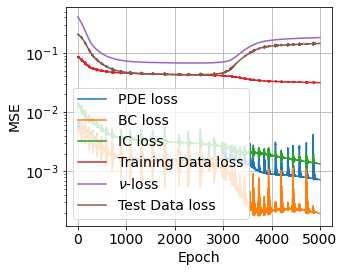

In [37]:
fig, ax = plt.subplots(figsize=(5,4))
ax.semilogy(loss_pde.detach(), label='PDE loss')
ax.semilogy(loss_bc.detach(), label='BC loss')
ax.semilogy(loss_ic.detach(), label='IC loss')
ax.semilogy(loss_data, label='Training Data loss')
ax.semilogy(loss_nu, label=r'$\nu$-loss')
ax.semilogy(loss_test.detach(), label='Test Data loss')
ax.legend()
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.grid()
fig.tight_layout()
# fig.savefig('./figs/hyperparams/Burger_loss_' + model_name + '.png', dpi=600)

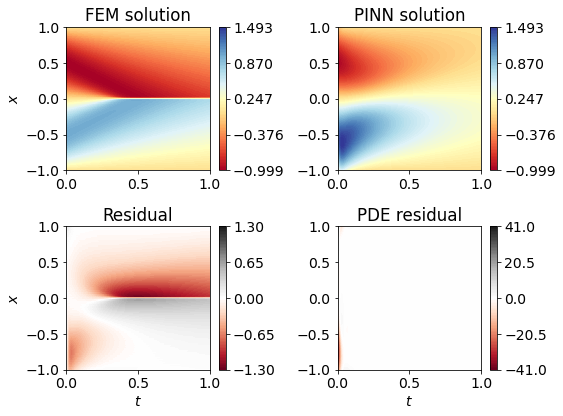

In [193]:
## Evaluate network
fig, axs = plt.subplots(2,2,figsize=(8,6))
axs = axs.flatten()
u_hat = net(x_eval, t_eval).detach().reshape(u_.shape)
pde_hat = net.PDE(x_eval, t_eval).detach().reshape(u_.shape)
vmin = u_hat.min()
vmax = u_hat.max()

levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)

m = axs[0].contourf(t_.detach(), x_.detach(), u_.detach(), levels=levels, cmap='RdYlBu')
cb = fig.colorbar(m, ax=axs[0])
cb.set_ticks(c_levels)
axs[0].set_title('FEM solution')
# axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$x$')

m = axs[1].contourf(t_.detach(), x_.detach(), u_hat.detach(), levels=levels, cmap='RdYlBu')
cb = fig.colorbar(m, ax=axs[1])
cb.set_ticks(c_levels)
axs[1].set_title('PINN solution')
# axs[1].set_xlabel('$t$')
# axs[1].set_ylabel('$x$')

vmin = -np.round((u_-u_hat).abs().max(),1)
vmax = -vmin
levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)

m = axs[2].contourf(t_.detach(), x_.detach(), (u_-u_hat).detach(), levels=levels, cmap='RdGy')
cb = fig.colorbar(m, ax=axs[2])
cb.set_ticks(c_levels)
axs[2].set_title('Residual')
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$x$')

vmin = -np.round(pde_hat.abs().max(),0)
vmax = -vmin
levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)
m = axs[3].contourf(t_.detach(), x_.detach(), pde_hat.detach(), levels=levels, vmin=vmin, vmax=vmax, cmap='RdGy')
cb = fig.colorbar(m, ax=axs[3])
cb.set_ticks(c_levels)
axs[3].set_title('PDE residual')
axs[3].set_xlabel('$t$')
# axs[3].set_ylabel('$x$')

fig.tight_layout()
# fig.savefig('./figs/hyperparams/burgers_2D_' + model_name + '.png', dpi=600)


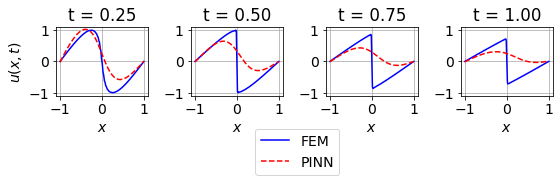

In [130]:
xi, ti = torch.meshgrid(torch.linspace(xmin,xmax,N_x, requires_grad=True), torch.tensor([0.25, 0.5, 0.75, 1]))
#xi, ti = xi.reshape(4, -1), ti.reshape(4, -1)
fig, axs = plt.subplots(1,4,figsize=(8,2.2))
for k, ax in enumerate(axs):
    x = xi[:, k].reshape(-1,1)
    t = ti[:, k].reshape(-1,1)
    u_hat = net(x, t).detach()
    ax.plot(x.detach(), u_[:, (k+1)*25], color='blue', ls='-')
    ax.plot(x.detach(), u_hat, color='red', ls='--')
    ax.set_xlabel('$x$')
    ax.set_title('t = {:.2f}'.format(t[0].item()))
    ax.set_ylim([-1-0.1,1+0.1])
    ax.grid()
axs[0].set_ylabel('$u(x,t)$')
fig.legend(['FEM', 'PINN'], loc="lower center", bbox_to_anchor=(0.53, -0.2))
fig.tight_layout()
# fig.savefig('./figs/hyperparams/burger_eval_1D_' + model_name + '.pdf', bbox_inches='tight')

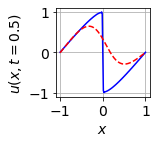

In [131]:
t_eval = 0.5
xi, ti = torch.meshgrid(torch.linspace(xmin,xmax,N_x, requires_grad=True), torch.tensor([t_eval]))
u_hat = net(xi, ti).detach()

f = plt.figure(figsize=(2.4,2.2))
plt.plot(x.detach(), u_[:, T_ == t_eval], color='blue', ls='-')
plt.plot(x.detach(), u_hat, color='red', ls='--')
plt.xlabel('$x$')
plt.ylabel('$u(x,t=0.5)$')
# plt.title('$t = {:.2f}$'.format(t_eval))
plt.ylim([-1-0.1,1+0.1])
plt.grid()
plt.tight_layout()
# f.savefig('./figs/hyperparams/1D_' + model_name + '.pdf', bbox_inches='tight')
plt.show()